# Chapter3 線形回帰モデル

回帰の目的は、連続する目的変数tの値を、D次元の入力変数ベクトルxの値に基づいて予測することである。

線形回帰モデルは調整可能なパラメータの線形関数であり、最も単純な形式では入力変数の線形関数でもある。しかし、非線形の基底関数を用いることで、より多様なクラスの関数を得ることができる。

N個の観測値と対応する目的値が与えられた場合、新しい入力$x$に対応する$t$の値を予測することが目的である。最も単純な方法では、新しい入力$x$に対応する$t$の値の予測として機能する適切な関数$y(x)$を直接構築することができる。さらに一般的には、条件付き分布$p(t∣x)$をモデル化し、適切に選ばれた損失関数の期待値を最小化する方法で$t$の予測を行う。実数値変数の損失関数としてよく使用されるのが二乗損失で、その最適解は$t$の条件付き期待値で与えられる。

## 3.1 線形基底関数モデル

最も単純な線形回帰モデルは
$$
y(\mathbf{x}, \mathbf{w}) = w_0 + w_1x_1 + ... + w_Dx_D
$$
に関するものである。これは単に**線形回帰**と呼ばれる。

これは表現能力が乏しくすぎるため、非線形な関数の線形結合を考える。
$$
y(\mathbf{x}, \mathbf{w}) = w_0 + \sum_{j=0}^{M-1}{w_j\phi{(\mathbf{x})}}
$$

$\phi{(\mathbf{x})}$を**基底関数**と呼ぶ。

パラメータ$w_0$はデータの任意の固定されたオフセット量を許容するものであり、**バイアスパラメータ**と呼ばれることがある。

Chapter1で説明した多項式基底関数の制限の一つは、入力変数のグローバル関数であるため、入力空間の一部の変更が他のすべての部分に影響を与えることである。これは、入力空間を領域に分割し、各領域で異なる多項式を適合させることで解決でき、**スプライン関数**と呼ぶ。

基底関数にはほかにもたくさんの選択肢があり、ガウス基底関数や、シグモイド基底関数などが挙げられる。どちらもパラメータ$w_j$がかかっているため正規化する必要はない。

$$
\phi_j{(x)} = 
\exp{\left\{ -\frac{(x-\mu_j)^2}{2\sigma^2} \right\}}\\
$$

$$
\phi_j{(x)} = 
\sigma{\left( \frac{x-\mu_j}{s} \right)}\\
\sigma{(a)} = 
\frac{1}{1 + \exp(-a)}
$$

以降の事項は基本的に基底関数の選択に依存しない。

### 3.1.1 最尤推定と最小二乗法

目的変数tが線形回帰モデルに以下で表される精度$\beta$のガウスノイズがかかっているとすると

$$
\epsilon = N(\epsilon | 0, \beta^{-1})\\
t = y(\mathbf{x}, \mathbf{w}) + \epsilon
$$

このとき、tは平均$y(\mathbf{x}, \mathbf{w})$、精度$\beta$のガウス分布で表すことができる。

$$
p(t|\mathbf{x}, \mathbf{w}, \beta) = 
N(t|y(\mathbf{x}, \mathbf{w}), \beta^{-1}) = 
N(t | \mathbf{w}^T \phi{(\mathbf{x})}, \beta^{-1})
$$

次に独立に生成された、N個の入力値と目的値について考えると、尤度関数は
$$
p(\mathbf{t} | \mathbf{X}, \mathbf{w}, \beta) = 
\prod_{n=1}^N{N(t_n|\mathbf{w}^T\phi{(\mathbf{x}_n)}, \beta^{-1})}
$$

以降、$\mathbf{x}$は条件としてしか現れないため、省略する。

尤度関数の対数を取ると、
$$
\ln p(\mathbf{t}|\mathbf{w}, \beta) = 
\sum_{n=1}^{N} \ln N(t_n | \mathbf{w}^T\phi{(x_n)}, \beta^{-1}) = 
\frac{N}{2}\ln {\beta} - \frac{N}{2}\ln {2\pi} - \beta E_D(\mathbf{w})
$$

最後の項は二乗和誤差である。
$$
E_D(\mathbf{w}) = \frac{1}{2}\sum_{n=1}^{N} {\left\{ t_n - \mathbf{w}^T\phi{\left(x_n\right)} \right\}^2}
$$

最尤推定によって$\mathbf{w}$と$\beta$を決定する。\
まずは$\mathbf{w}$に関して解いた結果は、
$$
\mathbf{w}_{ML} = \left(\Phi^T \Phi \right)^{-1} \Phi^T \mathbf{t}\\
\Phi_{nj} = \phi_j{(x_n)}
$$

$\Phi$は**計画行列**と呼ばれる。

また、$\beta$に関して解いた結果は、

$$
\frac{1}{\beta_{ML}} = \frac{1}{N} \sum_{n=1}^{N} {\left\{ t_n - \mathbf{w_{ML}}^T\phi{\left(x_n\right)} \right\}^2}
$$

In [177]:
import numpy as np
import matplotlib.pyplot as plt

In [178]:
# 真の関数
def true_function(x):
    return 2 * np.cos(2 * np.pi * x) ** 2 - 1 + 4 * x ** 2 - 2 * x ** 3

In [179]:
# データ生成
np.random.seed(0)
n_samples = 101
x_vals = np.linspace(0, 1, num=n_samples)
beta_true = 3.0
sigma_true = np.sqrt(1 / beta_true)
print(sigma_true)

0.5773502691896257


In [180]:
y_true_vals = true_function(x_vals)
print(y_true_vals[:5])

[1.         0.9925127  0.97016716 0.93332249 0.88257868]


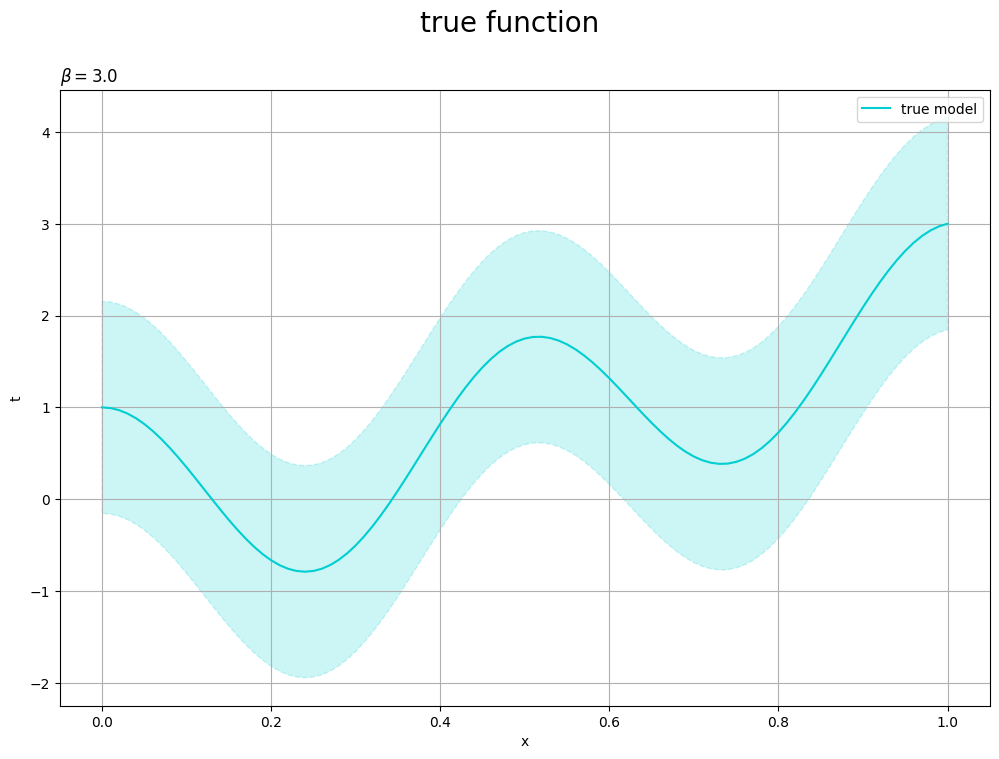

In [181]:
plt.figure(figsize=(12, 8))
plt.plot(x_vals, y_true_vals, color='darkturquoise', label='true model') # 真のモデル
plt.fill_between(x=x_vals, y1=y_true_vals-2.0*sigma_true, y2=y_true_vals+2.0*sigma_true, 
                 color='darkturquoise', alpha=0.2, linestyle='--') # 真のノイズ範囲
plt.xlabel('x')
plt.ylabel('t')
plt.suptitle('true function', fontsize=20)
plt.title('$\\beta=' + str(beta_true) + '$', loc='left')
plt.grid()
plt.legend()
plt.show()

In [182]:
# データ数を指定
N = 100

# データを生成
x_n = np.random.uniform(low=np.min(x_vals), high=np.max(x_vals), size=N)
t_n = true_function(x_n) + np.random.normal(loc=0.0, scale=sigma_true, size=N)

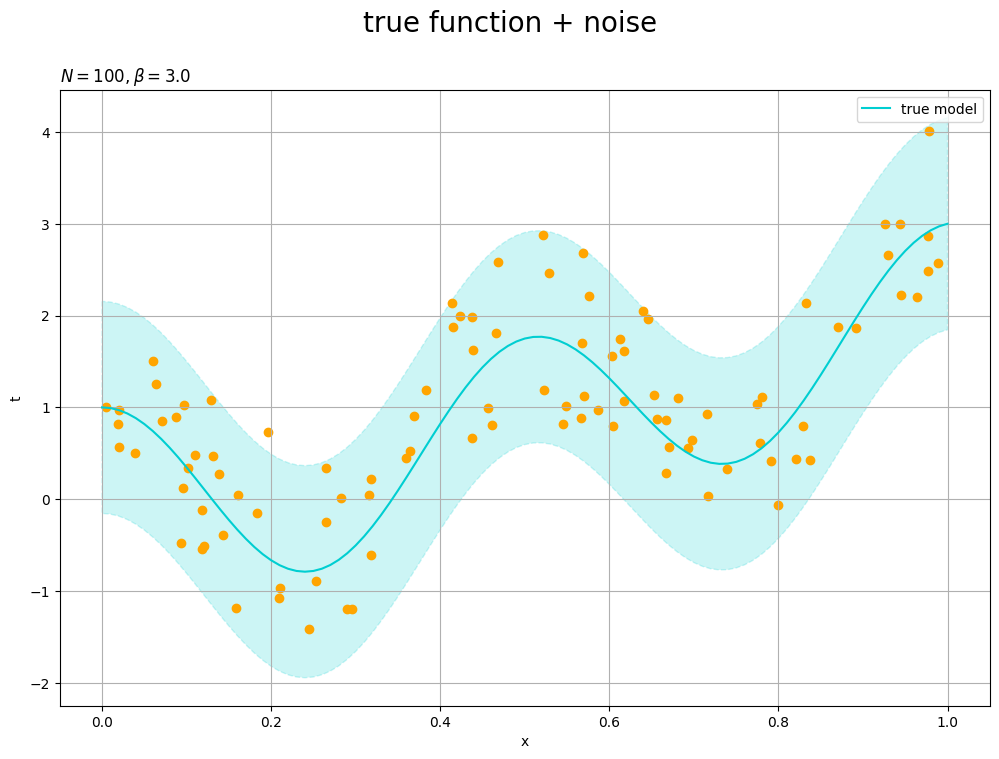

In [183]:
# 観測データの散布図を作成
plt.figure(figsize=(12, 8))
plt.plot(x_vals, y_true_vals, color='darkturquoise', label='true model') # 真のモデル
plt.fill_between(x=x_vals, y1=y_true_vals-2.0*sigma_true, y2=y_true_vals+2.0*sigma_true, 
                 color='darkturquoise', alpha=0.2, linestyle='--') # 真のノイズ範囲
plt.scatter(x_n, t_n, color='orange') # 観測データ
plt.xlabel('x')
plt.ylabel('t')
plt.suptitle('true function + noise', fontsize=20)
plt.title('$N=' + str(N) + ', \\beta=' + str(beta_true) + '$', loc='left')
plt.grid()
plt.legend()
plt.show()

In [184]:
class Polynomial(object):
    def __init__(self, M) -> None:
        self.M = M
        self.coef_ = np.zeros(M)
        self.beta_ = 0


    # 多項式基底関数を作成
    def phi_polynomial(self, x, j):
        return x**j


    # 多項式基底関数の計画行列を作成:(M > 2)
    def cal_design_matrix(self, x):

        design_matrix = np.ones((len(x), self.M))
        # 列ごとに多項式基底関数による変換
        for m in range(1, self.M):
            design_matrix[:, m] = self.phi_polynomial(x, m)
        return design_matrix
    
    
    def fit(self, x, t, regularization=None, lam=None):
        if regularization == None:
            # 重みパラメータの最尤解を計算
            self.design_matrix_fit = self.cal_design_matrix(x)
            self.coef_ = np.linalg.inv(np.dot(self.design_matrix_fit.T, self.design_matrix_fit)).dot(self.design_matrix_fit.T).dot(t.reshape(-1, 1)).flatten()
            self.beta_ = 1 / (np.sum((t - np.dot(self.design_matrix_fit, self.coef_.reshape(-1, 1)).flatten())**2) / len(x))
        
        if regularization == "Ridge":
            # 重みパラメータの最尤解を計算
            self.design_matrix_fit = self.cal_design_matrix(x)
            self.coef_ = np.linalg.inv(lam * np.ones((self.M, self.M)) + np.dot(self.design_matrix_fit.T, self.design_matrix_fit)).dot(self.design_matrix_fit.T).dot(t.reshape(-1, 1)).flatten()
            self.beta_ = 1 / (np.sum((t - np.dot(self.design_matrix_fit, self.coef_.reshape(-1, 1)).flatten())**2) / len(x))
        
        
    def predict(self, x):
        self.design_matrix_predict = self.cal_design_matrix(x)
        return np.dot(self.design_matrix_predict , self.coef_.reshape(-1, 1)).flatten()

In [185]:
# 基底関数の数を指定
M = 6

# 基底関数を指定
phi = Polynomial(M=M)

phi.fit(x=x_n, t=t_n, regularization="Ridge", lam=0.01)
print(phi.coef_)
print(phi.beta_)

[   1.77006404  -26.80436098  105.67689549 -109.30680106  -23.95440123
   56.79550521]
2.162320306142733


In [186]:
# 回帰曲線を計算
y_ml_vals = phi.predict(x_vals)

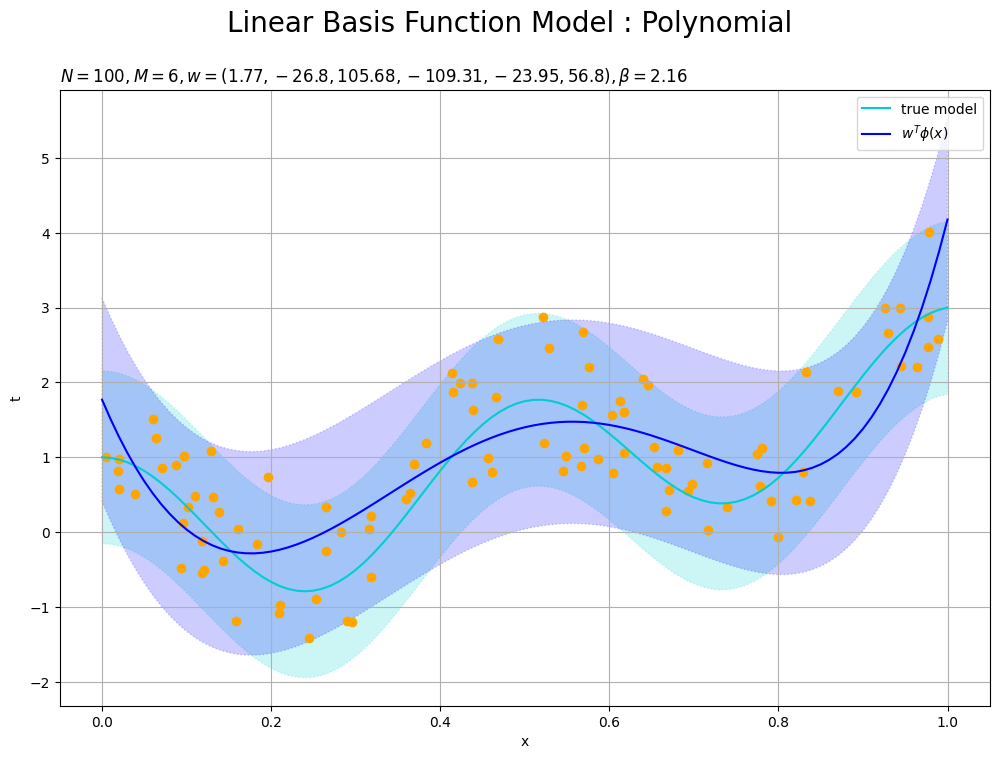

In [187]:
# 回帰曲線を作図
plt.figure(figsize=(12, 8))
plt.plot(x_vals, y_true_vals, color='darkturquoise', label='true model') # 真のモデル
plt.fill_between(x=x_vals, y1=y_true_vals-2.0*sigma_true, y2=y_true_vals+2.0*sigma_true, 
                 color='darkturquoise', alpha=0.2, linestyle=':') # 真のノイズ範囲
plt.plot(x_vals, y_ml_vals, color='blue', label='$w^T \phi(x)$') # 推定したモデル
plt.fill_between(x=x_vals, y1=y_ml_vals-2.0*1/np.sqrt(phi.beta_), y2=y_ml_vals+2.0*1/np.sqrt(phi.beta_), 
                 color='blue', alpha=0.2, linestyle=':') # 推定したノイズ範囲
plt.scatter(x_n, t_n, color='orange') # 観測データ
plt.xlabel('x')
plt.ylabel('t')
plt.suptitle('Linear Basis Function Model : Polynomial', fontsize=20)
plt.title('$N=' + str(N) + ', M=' + str(M) + 
          ', w=(' + ', '.join([str(w) for w in np.round(phi.coef_, 2)]) + ')' + 
          ', \\beta=' + str(np.round(phi.beta_, 2)) + '$', loc='left')
plt.legend()
plt.grid()
plt.show()

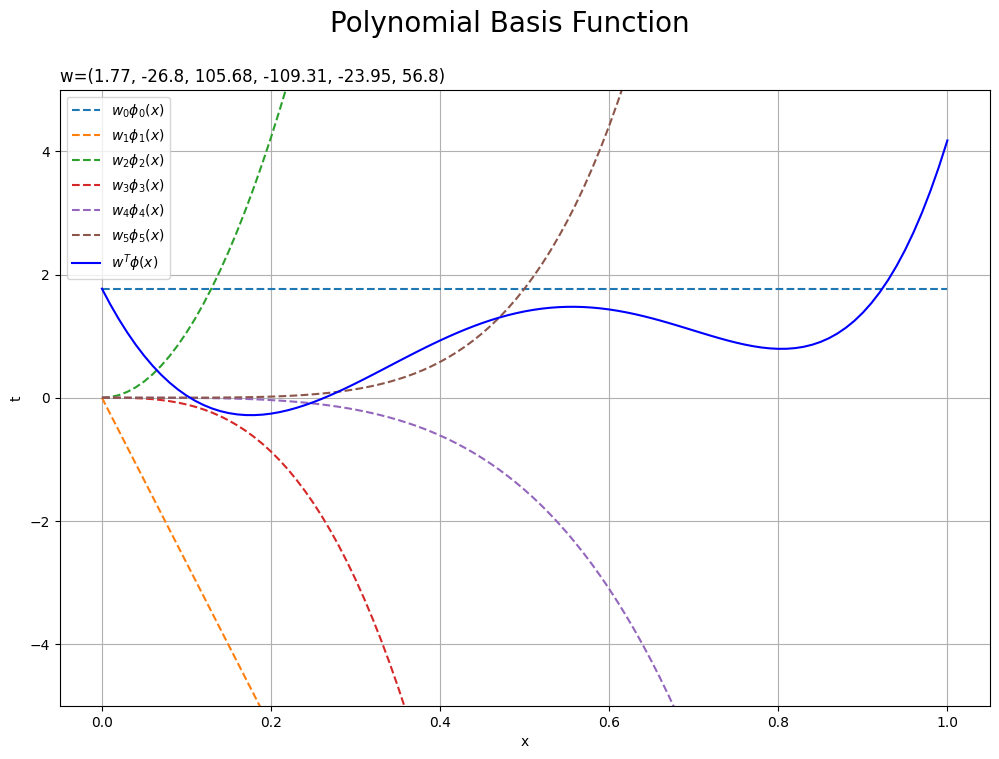

In [188]:
# 重み付き基底関数を作図
plt.figure(figsize=(12, 8))
for m in range(M):
    plt.plot(x_vals, phi.coef_[m] * phi.design_matrix_predict[:, m], 
             linestyle='--', label='$w_' + str(m) + '\phi_' + str(m) + '(x)$') # 重み付き基底関数
plt.plot(x_vals, y_ml_vals, color='blue', label='$w^T \phi(x)$')
plt.xlabel('x')
plt.ylabel('t')
plt.suptitle('Polynomial Basis Function', fontsize=20)
plt.title('w=(' + ', '.join([str(w) for w in np.round(phi.coef_, 2)]) + ')', loc='left')
plt.legend()
plt.grid()
plt.ylim(-5, 5)
plt.show()

In [189]:
class GaussianBasis(object):
    def __init__(self, M=6, s=1.0) -> None:
        self.M = M
        self.s = s
        self.coef_ = np.zeros(M)
        self.beta_ = 0


    # ガウス基底関数を作成
    def phi_gauss(self, x, mu, s):
        return np.exp(-0.5 * (x - mu)**2 / s**2)


    # ガウス基底関数の計画行列を作成:(M > 2)
    def cal_design_matrix(self, x):
        # パラメータ設定用の入力値を設定
        
        _x_n = x.copy()
        s = np.std(_x_n)  # 標準偏差で固定

        if self.M == 2:
            mu_m = np.array([np.mean(_x_n)])
        elif self.M == 3:
            sgm = s * 1.0
            mu_m = np.array([np.mean(_x_n) - sgm, np.mean(_x_n) + sgm])
        else:
            sgm = s * 0.25
            mu_m = np.linspace(np.min(_x_n) + sgm, np.max(_x_n) - sgm, num=self.M - 1)

        # 変数を初期化
        design_matrix = np.ones((len(x), self.M))

        # 列ごとにガウス基底関数による変換
        for m in range(1, self.M):
            design_matrix[:, m] = self.phi_gauss(x, mu_m[m - 1], s)

        return design_matrix
    
    
    def fit(self, x, t, regularization=None, lam=None):
        if regularization == None:
            # 重みパラメータの最尤解を計算
            self.design_matrix_fit = self.cal_design_matrix(x)
            self.coef_ = np.linalg.inv(np.dot(self.design_matrix_fit.T, self.design_matrix_fit)).dot(self.design_matrix_fit.T).dot(t.reshape(-1, 1)).flatten()
            self.beta_ = 1 / (np.sum((t - np.dot(self.design_matrix_fit, self.coef_.reshape(-1, 1)).flatten())**2) / len(x))
        
        if regularization == "Ridge":
            # 重みパラメータの最尤解を計算
            self.design_matrix_fit = self.cal_design_matrix(x)
            self.coef_ = np.linalg.inv(lam * np.ones((self.M, self.M)) + np.dot(self.design_matrix_fit.T, self.design_matrix_fit)).dot(self.design_matrix_fit.T).dot(t.reshape(-1, 1)).flatten()
            self.beta_ = 1 / (np.sum((t - np.dot(self.design_matrix_fit, self.coef_.reshape(-1, 1)).flatten())**2) / len(x))
        
    def predict(self, x):
        self.design_matrix_predict = self.cal_design_matrix(x)
        return np.dot(self.design_matrix_predict , self.coef_.reshape(-1, 1)).flatten()


In [190]:
# 基底関数の数を指定
M = 10

# 基底関数を指定
phi = GaussianBasis(M=M)

phi.fit(x=x_n, t=t_n, regularization="Ridge", lam=0.1)
print(phi.coef_)
print(phi.beta_)

[-1.84305478e+01 -3.35935089e+03  1.79879754e+04 -4.65147429e+04
  7.65884109e+04 -8.81812441e+04  7.28605810e+04 -4.21300741e+04
  1.55227600e+04 -2.75588535e+03]
3.159137806855171


In [191]:
# 回帰曲線を計算
y_ml_vals = phi.predict(x_vals)

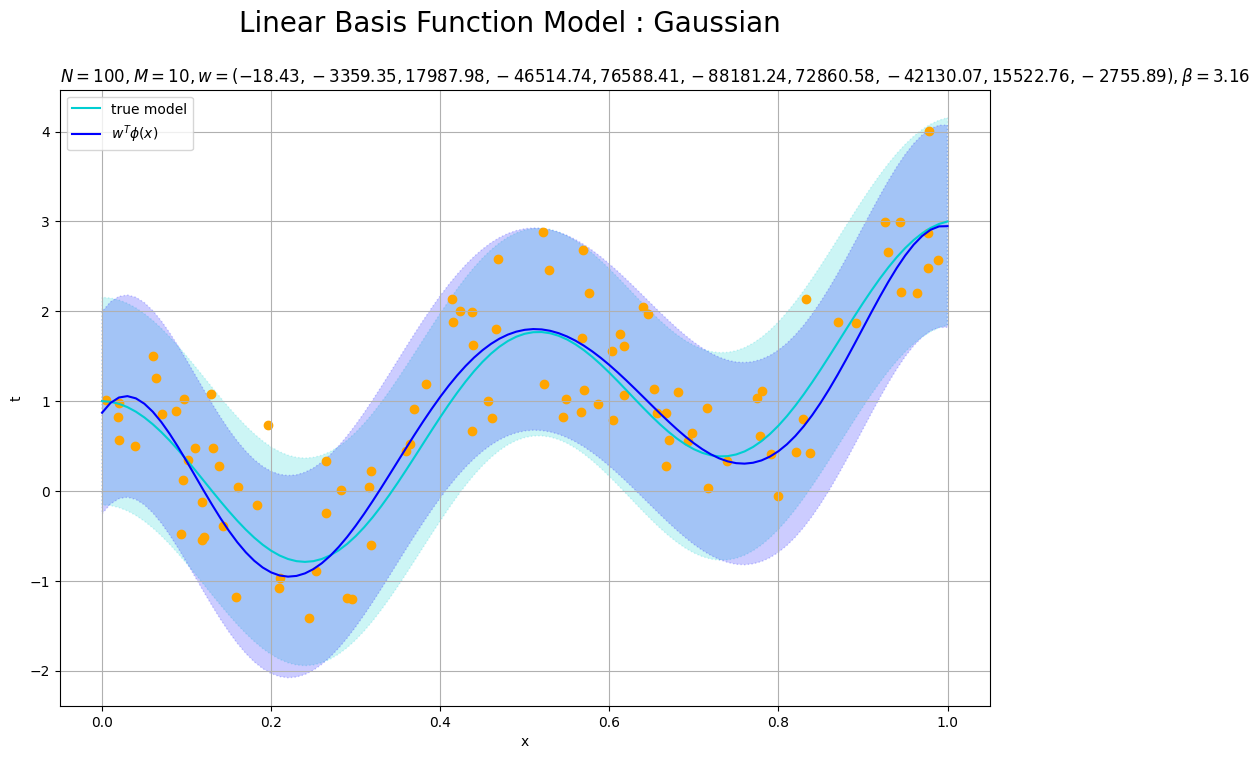

In [192]:
# 回帰曲線を作図
plt.figure(figsize=(12, 8))
plt.plot(x_vals, y_true_vals, color='darkturquoise', label='true model') # 真のモデル
plt.fill_between(x=x_vals, y1=y_true_vals-2.0*sigma_true, y2=y_true_vals+2.0*sigma_true, 
                 color='darkturquoise', alpha=0.2, linestyle=':') # 真のノイズ範囲
plt.plot(x_vals, y_ml_vals, color='blue', label='$w^T \phi(x)$') # 推定したモデル
plt.fill_between(x=x_vals, y1=y_ml_vals-2.0*1/np.sqrt(phi.beta_), y2=y_ml_vals+2.0*1/np.sqrt(phi.beta_), 
                 color='blue', alpha=0.2, linestyle=':') # 推定したノイズ範囲
plt.scatter(x_n, t_n, color='orange') # 観測データ
plt.xlabel('x')
plt.ylabel('t')
plt.suptitle('Linear Basis Function Model : Gaussian', fontsize=20)
plt.title('$N=' + str(N) + ', M=' + str(M) + 
         ', w=(' + ', '.join([str(w) for w in np.round(phi.coef_, 2)]) + ')' + 
          ', \\beta=' + str(np.round(phi.beta_, 2)) + '$', loc='left')
plt.legend()
plt.grid()
plt.show()

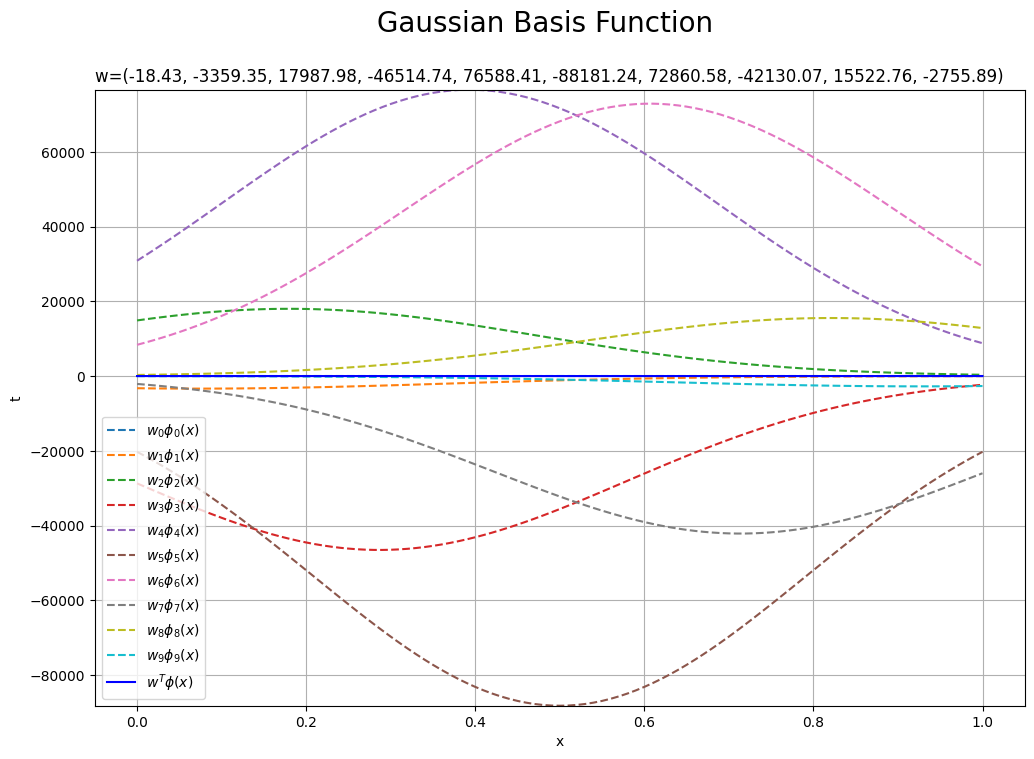

In [193]:
# 重み付き基底関数を作図
plt.figure(figsize=(12, 8))
for m in range(M):
    plt.plot(x_vals, phi.coef_[m] * phi.design_matrix_predict[:, m], 
             linestyle='--', label='$w_' + str(m) + '\phi_' + str(m) + '(x)$') # 重み付き基底関数
plt.plot(x_vals, y_ml_vals, color='blue', label='$w^T \phi(x)$')
plt.xlabel('x')
plt.ylabel('t')
plt.suptitle('Gaussian Basis Function', fontsize=20)
plt.title('w=(' + ', '.join([str(w) for w in np.round(phi.coef_, 2)]) + ')', loc='left')
plt.legend()
plt.grid()
plt.ylim(np.min(phi.coef_), np.max(phi.coef_))
plt.show()

In [194]:
class SigmoidBasis(object):
    def __init__(self, M=6, s=1.0) -> None:
        self.M = M
        self.s = s
        self.coef_ = np.zeros(M)
        self.beta_ = 0


    # ロジスティックシグモイド関数を作成
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))


    # シグモイド基底関数を作成
    def phi_sigmoid(self, x, mu, s):
        a_n = (x - mu) / s
        return self.sigmoid(a_n)


    # ガウス基底関数の計画行列を作成:(M > 2)
    def cal_design_matrix(self, x):
        # パラメータ設定用の入力値を設定
        
        _x_n = x.copy()
        s = np.std(_x_n)  # 標準偏差で固定

        if self.M == 2:
            mu_m = np.array([np.mean(_x_n)])
        elif self.M == 3:
            sgm = s * 1.0
            mu_m = np.array([np.mean(_x_n) - sgm, np.mean(_x_n) + sgm])
        else:
            sgm = s * 0.25
            mu_m = np.linspace(np.min(_x_n) + sgm, np.max(_x_n) - sgm, num=self.M - 1)

        # 変数を初期化
        design_matrix = np.ones((len(x), self.M))

        # 列ごとにガウス基底関数による変換
        for m in range(1, self.M):
            design_matrix[:, m] = self.phi_sigmoid(x, mu_m[m - 1], s)

        return design_matrix
    
    
    def fit(self, x, t, regularization=None, lam=None):
        if regularization == None:
            # 重みパラメータの最尤解を計算
            self.design_matrix_fit = self.cal_design_matrix(x)
            self.coef_ = np.linalg.inv(np.dot(self.design_matrix_fit.T, self.design_matrix_fit)).dot(self.design_matrix_fit.T).dot(t.reshape(-1, 1)).flatten()
            self.beta_ = 1 / (np.sum((t - np.dot(self.design_matrix_fit, self.coef_.reshape(-1, 1)).flatten())**2) / len(x))
        
        if regularization == "Ridge":
            # 重みパラメータの最尤解を計算
            self.design_matrix_fit = self.cal_design_matrix(x)
            self.coef_ = np.linalg.inv(lam * np.ones((self.M, self.M)) + np.dot(self.design_matrix_fit.T, self.design_matrix_fit)).dot(self.design_matrix_fit.T).dot(t.reshape(-1, 1)).flatten()
            self.beta_ = 1 / (np.sum((t - np.dot(self.design_matrix_fit, self.coef_.reshape(-1, 1)).flatten())**2) / len(x))
        
        
    def predict(self, x):
        self.design_matrix_predict = self.cal_design_matrix(x)
        return np.dot(self.design_matrix_predict , self.coef_.reshape(-1, 1)).flatten()

In [195]:
# 基底関数を指定
phi = SigmoidBasis(M=10)

phi.fit(x=x_n, t=t_n, regularization="Ridge", lam=0.1)
print(phi.coef_)
print(phi.beta_)

[-2.57418238e+02  4.41664703e+04 -1.96475740e+05  4.25773697e+05
 -6.05654776e+05  6.28665087e+05 -4.83389394e+05  2.61532232e+05
 -8.81573226e+04  1.37971479e+04]
3.1248485574597127


In [196]:
# 回帰曲線を計算
y_ml_vals = phi.predict(x_vals)

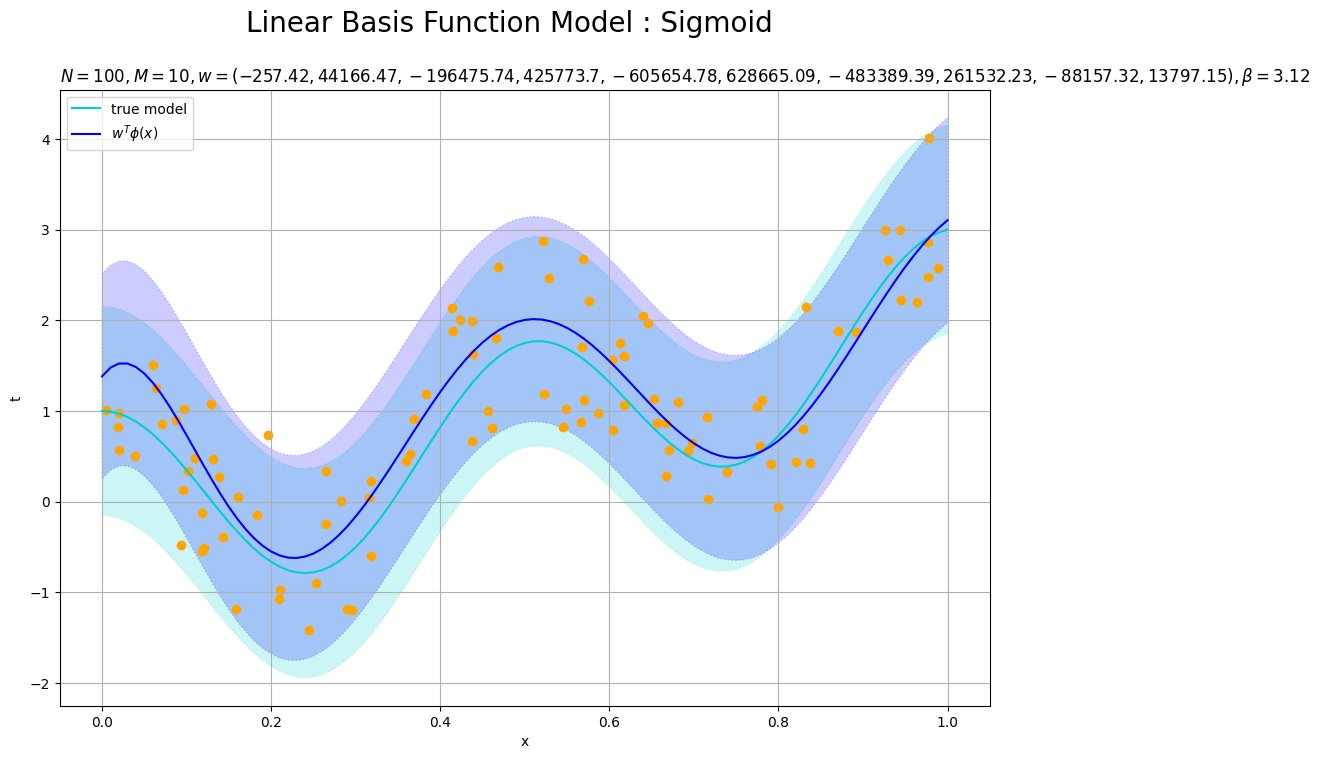

In [197]:
# 回帰曲線を作図
plt.figure(figsize=(12, 8))
plt.plot(x_vals, y_true_vals, color='darkturquoise', label='true model') # 真のモデル
plt.fill_between(x=x_vals, y1=y_true_vals-2.0*sigma_true, y2=y_true_vals+2.0*sigma_true, 
                 color='darkturquoise', alpha=0.2, linestyle=':') # 真のノイズ範囲
plt.plot(x_vals, y_ml_vals, color='blue', label='$w^T \phi(x)$') # 推定したモデル
plt.fill_between(x=x_vals, y1=y_ml_vals-2.0*1/np.sqrt(phi.beta_), y2=y_ml_vals+2.0*1/np.sqrt(phi.beta_), 
                 color='blue', alpha=0.2, linestyle=':') # 推定したノイズ範囲
plt.scatter(x_n, t_n, color='orange') # 観測データ
plt.xlabel('x')
plt.ylabel('t')
plt.suptitle('Linear Basis Function Model : Sigmoid', fontsize=20)
plt.title('$N=' + str(N) + ', M=' + str(M) + 
          ', w=(' + ', '.join([str(w) for w in np.round(phi.coef_, 2)]) + ')' + 
          ', \\beta=' + str(np.round(phi.beta_, 2)) + '$', loc='left')
plt.legend()
plt.grid()
plt.show()

### 

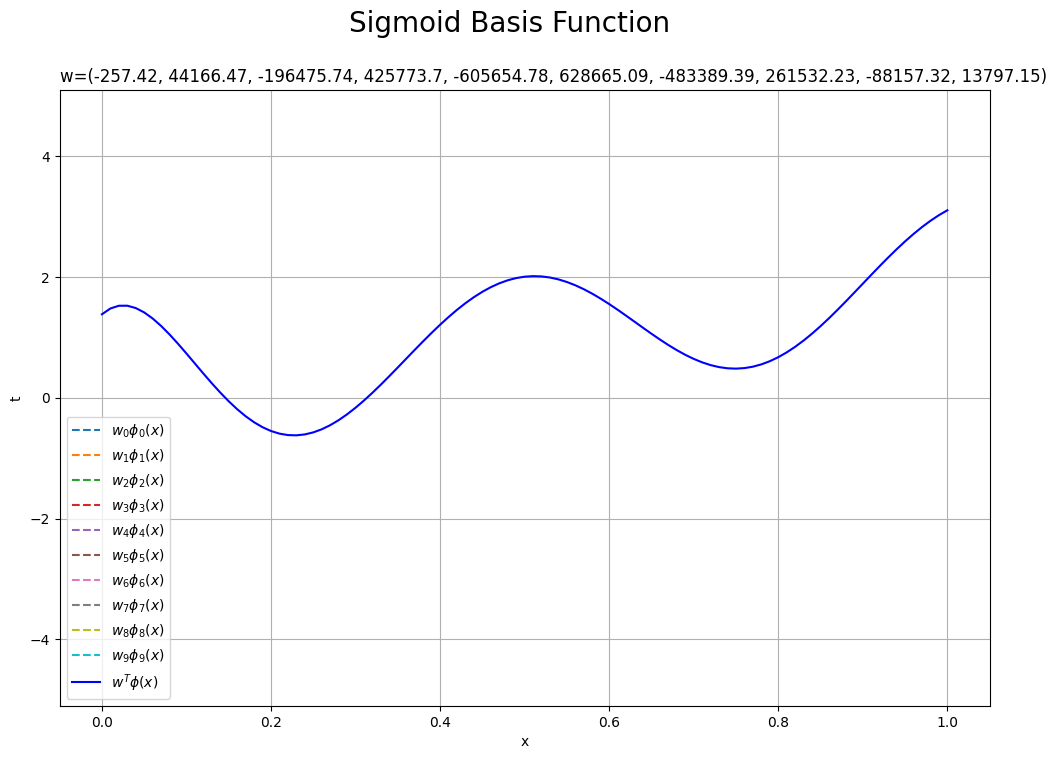

In [198]:
# 重み付き基底関数を作図
plt.figure(figsize=(12, 8))
for m in range(M):
    plt.plot(x_vals, phi.coef_[m] * phi.design_matrix_predict[:, m], 
             linestyle='--', label='$w_' + str(m) + '\phi_' + str(m) + '(x)$') # 重み付き基底関数
plt.plot(x_vals, y_ml_vals, color='blue', label='$w^T \phi(x)$')
plt.xlabel('x')
plt.ylabel('t')
plt.suptitle('Sigmoid Basis Function', fontsize=20)
plt.title('w=(' + ', '.join([str(w) for w in np.round(phi.coef_, 2)]) + ')', loc='left')
plt.legend()
plt.grid()
plt.ylim(-5.1, 5.1)
plt.show()

In [199]:
class FourierBasis(object):
    def __init__(self, M=3, freq=2*3.14) -> None:
        self.M = M
        self.freq = freq
        self.coef_ = np.zeros(2 * M + 1)
        self.beta_ = 0

    # フーリエ基底関数を作成
    def phi_fourier(self, x, j):
        if j == 0:
            return 1
        elif j % 2 == 0:
            return np.cos(j//2 * x * self.freq)
        else:
            return np.sin((j//2 + 1) * x * self.freq)

    # フーリエ基底関数の計画行列を作成(M > 3)
    def cal_design_matrix(self, x):
        design_matrix = np.ones((len(x), 2 * self.M + 1))
        # 列ごとにフーリエ基底関数による変換
        for m in range(1, 2 * self.M + 1):
            design_matrix[:, m] = self.phi_fourier(x, m)
        return design_matrix

    def fit(self, x, t, regularization=None, lam=None):
        if regularization == None:
            # 重みパラメータの最尤解を計算
            self.design_matrix_fit = self.cal_design_matrix(x)
            self.coef_ = np.linalg.inv(np.dot(self.design_matrix_fit.T, self.design_matrix_fit)).dot(self.design_matrix_fit.T).dot(t.reshape(-1, 1)).flatten()
            self.beta_ = 1 / (np.sum((t - np.dot(self.design_matrix_fit, self.coef_.reshape(-1, 1)).flatten())**2) / len(x))
        
        if regularization == "Ridge":
            # 重みパラメータの最尤解を計算
            self.design_matrix_fit = self.cal_design_matrix(x)
            self.coef_ = np.linalg.inv(lam * np.ones((2*self.M+1, 2*self.M+1)) + np.dot(self.design_matrix_fit.T, self.design_matrix_fit)).dot(self.design_matrix_fit.T).dot(t.reshape(-1, 1)).flatten()
            self.beta_ = 1 / (np.sum((t - np.dot(self.design_matrix_fit, self.coef_.reshape(-1, 1)).flatten())**2) / len(x))

    def predict(self, x):
        self.design_matrix_predict = self.cal_design_matrix(x)
        return np.dot(self.design_matrix_predict, self.coef_.reshape(-1, 1)).flatten()


In [206]:
# 基底関数を指定
M=3
phi = FourierBasis(M=3)

phi.fit(x=x_n, t=t_n, regularization="Ridge", lam=0.1)
print(phi.coef_)
print(phi.beta_)
print(phi.design_matrix_fit.shape)

[ 0.95218437 -0.68185037 -0.00203409 -0.36072348  1.00379071 -0.14985689
  0.07248175]
2.5466086591554324
(100, 7)


In [207]:
# 回帰曲線を計算
y_ml_vals = phi.predict(x_vals)

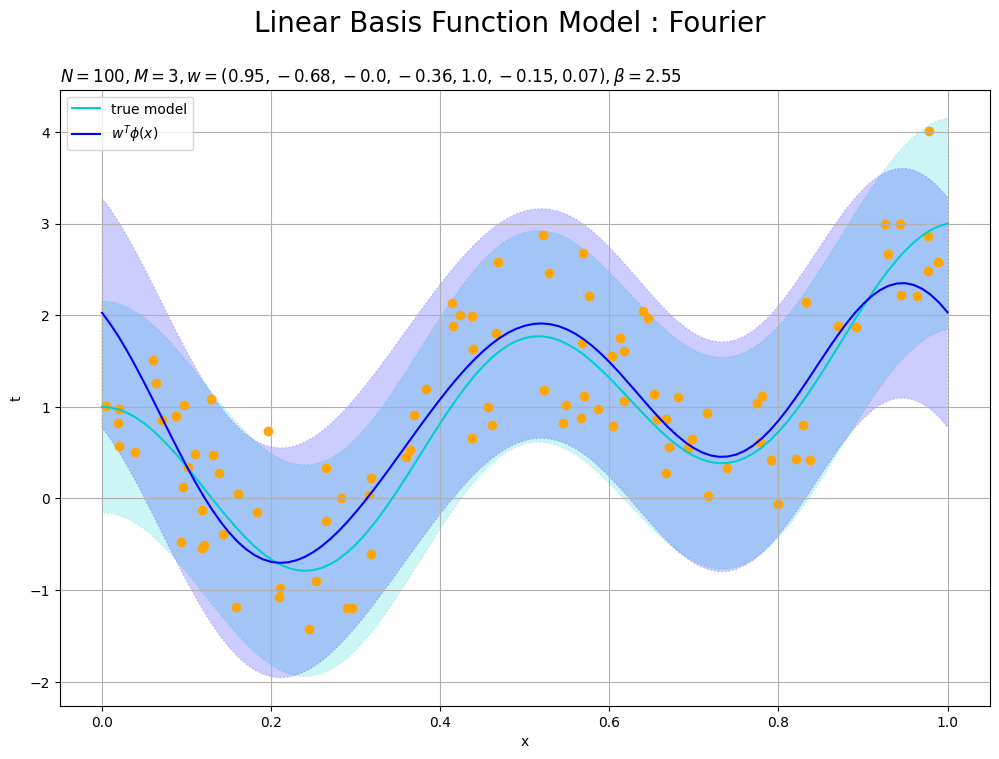

In [208]:
# 回帰曲線を作図
plt.figure(figsize=(12, 8))
plt.plot(x_vals, y_true_vals, color='darkturquoise', label='true model') # 真のモデル
plt.fill_between(x=x_vals, y1=y_true_vals-2.0*sigma_true, y2=y_true_vals+2.0*sigma_true, 
                 color='darkturquoise', alpha=0.2, linestyle=':') # 真のノイズ範囲
plt.plot(x_vals, y_ml_vals, color='blue', label='$w^T \phi(x)$') # 推定したモデル
plt.fill_between(x=x_vals, y1=y_ml_vals-2.0*1/np.sqrt(phi.beta_), y2=y_ml_vals+2.0*1/np.sqrt(phi.beta_), 
                 color='blue', alpha=0.2, linestyle=':') # 推定したノイズ範囲
plt.scatter(x_n, t_n, color='orange') # 観測データ
plt.xlabel('x')
plt.ylabel('t')
plt.suptitle('Linear Basis Function Model : Fourier', fontsize=20)
plt.title('$N=' + str(N) + ', M=' + str(M) + 
          ', w=(' + ', '.join([str(w) for w in np.round(phi.coef_, 2)]) + ')' + 
          ', \\beta=' + str(np.round(phi.beta_, 2)) + '$', loc='left')
plt.legend()
plt.grid()
plt.show()

In [209]:
print(phi.coef_)

[ 0.95218437 -0.68185037 -0.00203409 -0.36072348  1.00379071 -0.14985689
  0.07248175]


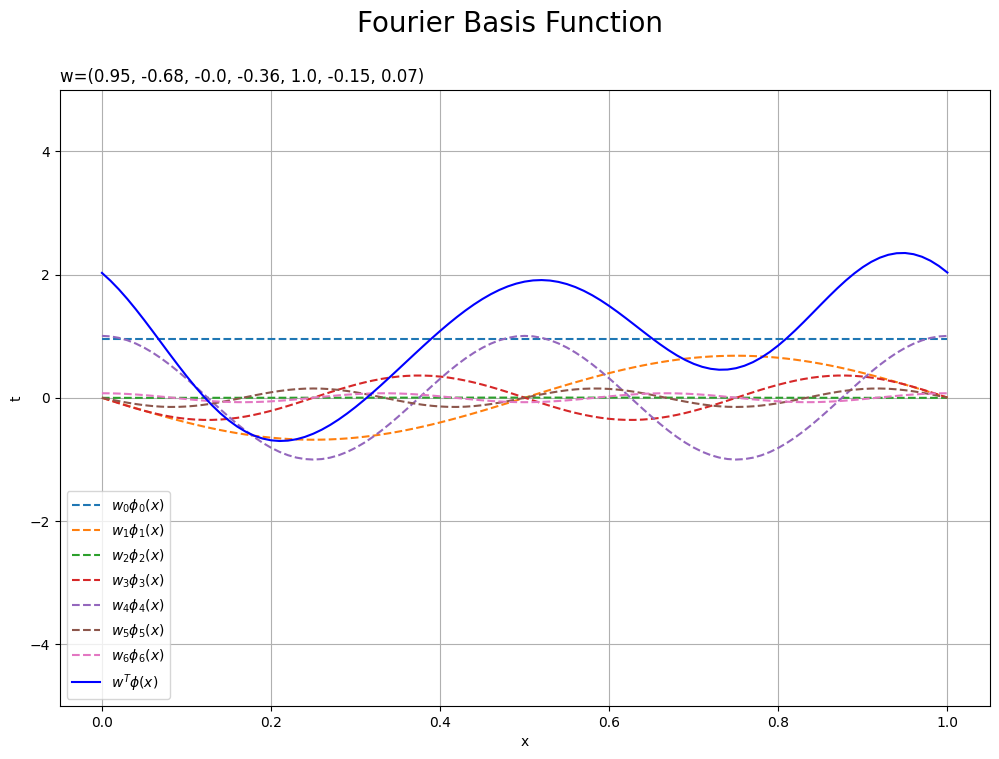

In [211]:
# 重み付き基底関数を作図
plt.figure(figsize=(12, 8))
for m in range(2*M+1):
    plt.plot(x_vals, phi.coef_[m] * phi.design_matrix_predict[:, m], 
             linestyle='--', label='$w_' + str(m) + '\phi_' + str(m) + '(x)$') # 重み付き基底関数
plt.plot(x_vals, y_ml_vals, color='blue', label='$w^T \phi(x)$')
plt.xlabel('x')
plt.ylabel('t')
plt.suptitle('Fourier Basis Function', fontsize=20)
plt.title('w=(' + ', '.join([str(w) for w in np.round(phi.coef_, 2)]) + ')', loc='left')
plt.legend()
plt.grid()
plt.ylim(-5, 5)
plt.show()